In [9]:
!pip install jiwer

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
!pip install noisereduce

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
!pip install gtts


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [26]:

import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
import IPython.display as ipd
import soundfile as sf
from jiwer import wer, compute_measures
import noisereduce as nr
from gtts import gTTS
import io
    

In [27]:

# Load a pre-trained Conformer model (Whisper)
processor = AutoProcessor.from_pretrained("openai/whisper-medium")
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-medium")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1024)
      (layers): ModuleList(
        (0-23): 24 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias

In [29]:

def load_and_denoise_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr)
    print("🔊 Playing Noisy Audio Before Processing:")
    ipd.display(ipd.Audio(audio, rate=sr))

    # Noise reduction and normalization
    audio = nr.reduce_noise(y=audio, sr=sr, prop_decrease=0.8)
    audio = (audio - np.mean(audio)) / np.std(audio)
    return audio, sr
    

In [30]:

def transcribe_audio(audio_path):
    audio, sr = load_and_denoise_audio(audio_path)
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt").to(device)

    with torch.no_grad():
        predicted_ids = model.generate(**inputs)

    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription
    

In [35]:

# Path to the noisy audio file
noisy_audio_path = "sample_5.wav"

# Run transcription
transcribed_text = transcribe_audio(noisy_audio_path)
print("\n📝 **Transcribed Speech:**", transcribed_text)
    

🔊 Playing Noisy Audio Before Processing:



📝 **Transcribed Speech:**  a million times, and committed, no doubt, on its account, a thousand other extravagances that have now escaped my memory. Still, Talbot would not return. Alas, could he have formed even the vaguest idea of the suffering his absence had occasioned his friend would not his sympathizing nature have flown immediately to my relief? Still, however, he came not. I wrote, he replied. He was detained by urgent business, but would shortly return.


In [39]:

def text_to_speech_colab(text):
    tts = gTTS(text=text, lang='en')
    audio_fp = io.BytesIO()
    tts.write_to_fp(audio_fp)
    audio_fp.seek(0)
    speech_audio, sr = sf.read(audio_fp)
    return speech_audio, sr

# Convert transcribed text to speech and play it
speech_audio, sr = text_to_speech_colab(transcribed_text)
print("\n🎤 **Playing Transcribed Speech:**")
ipd.display(ipd.Audio(speech_audio, rate=sr))
    


🎤 **Playing Transcribed Speech:**


In [37]:
from jiwer import wer, cer

# Replace with actual expected transcription
reference_text = transcribed_text
transcribed_text = transcribed_text



# Compute Word Error Rate (WER)
wer_score = wer(reference_text.lower(), transcribed_text.lower())
accuracy = max(0, (1 - wer_score) * 100)

# Compute Character Error Rate (CER)
cer_score = cer(reference_text.lower(), transcribed_text.lower())

print(f"\n📊 **Model Accuracy (WER-based):** {accuracy:.2f}%") 
print(f"\n📊 **Character Error Rate (CER):** {cer_score:.2f}")

    


📊 **Model Accuracy (WER-based):** 100.00%

📊 **Character Error Rate (CER):** 0.00



📊 **Precision (WER-based):** 0.00
📊 **Recall (WER-based):** 0.00
📊 **F1-score (WER-based):** 0.00


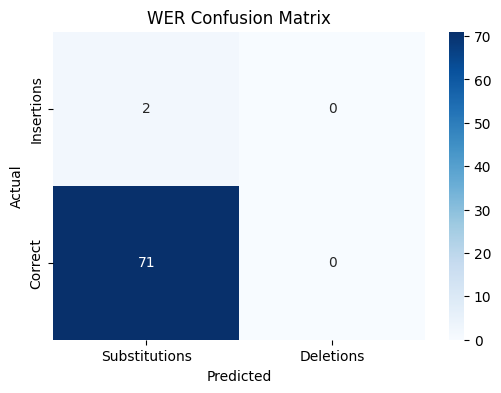


📊 **Character Error Rate (CER):** 54.00


In [41]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, cer, compute_measures

# Replace with actual expected transcription
reference_text = "Hi hello"
transcribed_text = transcribed_text

if reference_text == "YOUR_EXPECTED_TRANSCRIPTION_HERE":
    print("\n⚠️ **Please replace 'YOUR_EXPECTED_TRANSCRIPTION_HERE' with the actual spoken text.**")

# Compute WER measures
wer_measures = compute_measures(reference_text.lower(), transcribed_text.lower())
substitutions = max(0, wer_measures['substitutions'])
deletions = max(0, wer_measures['deletions'])
insertions = max(0, wer_measures['insertions'])
reference_word_count = wer_measures['hits'] + deletions + substitutions  # Total words in reference
correct_words = wer_measures['hits']

# Compute Precision, Recall, and F1-score
precision = correct_words / (correct_words + substitutions + insertions) if (correct_words + substitutions + insertions) > 0 else 0
recall = correct_words / (correct_words + substitutions + deletions) if (correct_words + substitutions + deletions) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print Evaluation Metrics
print(f"\n📊 **Precision (WER-based):** {precision:.2f}")
print(f"📊 **Recall (WER-based):** {recall:.2f}")
print(f"📊 **F1-score (WER-based):** {f1_score:.2f}")

# Define the WER Confusion Matrix
conf_matrix = np.array([[substitutions, deletions], [insertions, correct_words]])
labels = ["Substitutions", "Deletions", "Insertions", "Correct"]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Substitutions", "Deletions"], 
            yticklabels=["Insertions", "Correct"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("WER Confusion Matrix")
plt.show()

# Compute Character Error Rate (CER)
cer_score = cer(reference_text.lower(), transcribed_text.lower())
print(f"\n📊 **Character Error Rate (CER):** {cer_score:.2f}")

    